In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from typing import *

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.optimize import minimize_scalar
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

from utils import *

pio.renderers.default = "iframe"

### Linear regression

In [2]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

24/02/20 19:06:28 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.86.20 instead (on interface enp8s0)
24/02/20 19:06:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/20 19:06:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/20 19:06:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
base_path = "/data/saturation/thesis_run_20240130"
r_stat = 5
study_region_size = 2000 * 2000 / r_stat ** 2
MIN_N_SAMPLES = 300

configs_df = create_configs_df(read_configs(base_path, spark))
data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")

# State c2c nn dist in terms of r_stat and log-scale
data = data.where(
    (F.col("n_craters_added_in_study_region") > 50)
).select(
    "*",
    F.log10(F.col("center_to_center_nearest_neighbor_distance_mean") / F.lit(r_stat)).alias("log_mean_c2c_nn_dist"),
    F.log10("areal_density").alias("log_ad"),
    F.log10("n_craters_added_in_study_region").alias("log_n_craters_added_in_study_region"),
    (F.col("n_craters_in_study_region") / F.col("n_craters_added_in_study_region")).alias("information_remaining")
)

In [23]:
data_with_configs = join_configs(data, configs_df, spark).sample(0.005).cache()

## Draft - test for normal

In [7]:
df = data_with_configs.where(
    (F.col("slope").between(2.1, 2.2))
    & (F.col("log_mean_c2c_nn_dist") > 1.1)
).toPandas()

In [8]:
df.shape

(27094, 23)

In [15]:
d = data_with_configs.where(
    (F.col("slope").between(2.1, 2.2))
    & (F.col("log_mean_c2c_nn_dist") > 1.1)
)

assembler = VectorAssembler(
    inputCols=["log_mean_c2c_nn_dist"],
    outputCol="features"
)
train_df = assembler.transform(d)

model = LinearRegression(labelCol="log_n_craters_added_in_study_region", predictionCol="prediction", regParam=0.1, maxIter=1000, tol=1e-8).fit(train_df)

detrended = model.transform(train_df).select(
    (F.col("log_n_craters_added_in_study_region") - F.col("prediction")).alias("detrended"),
    "*"
)

(array([8.0000e+00, 1.4800e+02, 7.4400e+02, 1.8550e+03, 3.8770e+03,
        7.0740e+03, 1.0287e+04, 2.9530e+03, 1.2900e+02, 1.9000e+01]),
 array([-0.37898748, -0.31292241, -0.24685734, -0.18079227, -0.1147272 ,
        -0.04866213,  0.01740294,  0.083468  ,  0.14953307,  0.21559814,
         0.28166321]),
 <BarContainer object of 10 artists>)

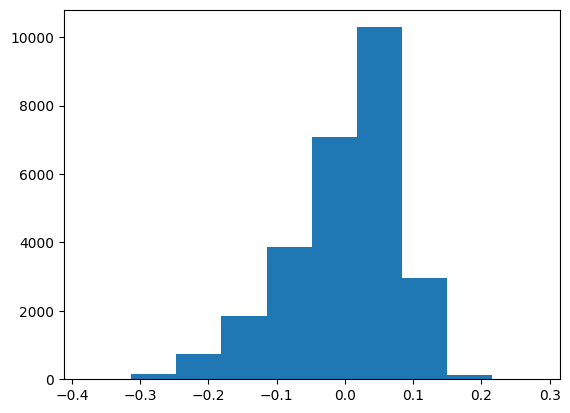

In [12]:
plt.hist(detrended.detrended)

In [18]:
detrended.select(
    F.percentile_approx("detrended", 0.95).alias("95th"),
).toPandas()

,95th
0,0.103061


In [28]:
test_df = assembler.transform(data_with_configs.sample(0.001))

detrended = model.transform(test_df).select(
    (F.col("log_n_craters_added_in_study_region") - F.col("prediction")).alias("detrended"),
    "*"
).toPandas()

In [29]:
detrended

,detrended,slope,min_rim_percentage,effective_radius_multiplier,r_stat_multiplier,crater_id,n_craters_added_in_study_region,n_craters_in_study_region,areal_density,areal_density_overlap_2,...,radius_stdev,z,za,simulation_id,log_mean_c2c_nn_dist,log_ad,log_n_craters_added_in_study_region,information_remaining,features,prediction
0,0.503218,2.007626,0.497174,1.228372,10.296207,2185736,12763,7528,0.448945,0.069340,...,16.386623,7.169245,67.272681,474,0.682084,-0.347807,4.105953,0.589830,[0.682084410368497],3.602735
1,0.977898,2.007626,0.497174,1.228372,10.296207,7303480,43040,9205,0.527644,0.095867,...,15.609177,12.176849,101.231870,474,0.647945,-0.277659,4.633872,0.213871,[0.6479448317775521],3.655974
2,1.003934,2.007626,0.497174,1.228372,10.296207,7836487,46124,9594,0.529338,0.101820,...,15.303827,15.402926,108.202806,474,0.645368,-0.276267,4.663927,0.208005,[0.6453677143541774],3.659993
3,1.052158,2.007626,0.497174,1.228372,10.296207,8786010,51642,9589,0.560383,0.116087,...,16.036105,15.091213,117.966644,474,0.644821,-0.251515,4.713003,0.185682,[0.6448212617197081],3.660845
4,1.185564,2.007626,0.497174,1.228372,10.296207,12047165,71140,9720,0.559199,0.113277,...,15.933847,14.860425,117.854206,474,0.641163,-0.252434,4.852114,0.136632,[0.641163487179596],3.666550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22394,1.119550,2.611930,0.535543,1.270201,9.360293,25351030,46874,7332,0.312178,0.038173,...,12.200680,18.120546,55.555231,9796,0.715014,-0.505598,4.670932,0.156419,[0.715013807135804],3.551382
22395,1.229631,2.611930,0.535543,1.270201,9.360293,32626878,60519,7367,0.300155,0.033979,...,11.783242,18.361530,54.027114,9796,0.714450,-0.522655,4.781892,0.121730,[0.7144504629893338],3.552261
22396,1.273611,2.611930,0.535543,1.270201,9.360293,36330877,67481,7415,0.287961,0.031553,...,11.252565,18.121195,51.964528,9796,0.712328,-0.540666,4.829182,0.109883,[0.7123281541395838],3.555571
22397,1.308783,2.611930,0.535543,1.270201,9.360293,38843651,72171,7283,0.281868,0.029296,...,11.168549,17.934597,50.557833,9796,0.716170,-0.549954,4.858363,0.100913,[0.7161696684297264],3.549580


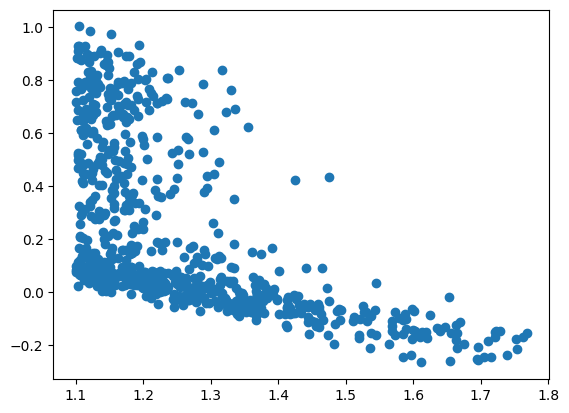

In [34]:
g = detrended[detrended.log_mean_c2c_nn_dist > 1.1]
plt.scatter(
    g.log_mean_c2c_nn_dist,
    g.detrended
)

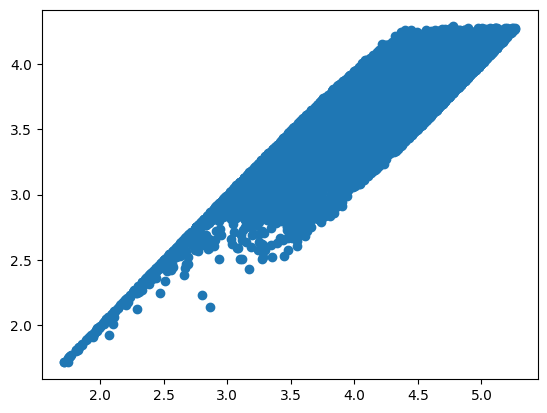

In [55]:
g = detrended[detrended.log_mean_c2c_nn_dist > 0.5]
plt.scatter(
    # g.log_mean_c2c_nn_dist,
    g.log_n_craters_added_in_study_region,
    np.log10(g.n_craters_in_study_region)
)

In [ ]:
"""
LOESS or other smoother - use the residuals of the model to construct 95% one-sided CI
Manually choose the 
"""

In [43]:
d = data_with_configs.where(
    (F.col("slope").between(2.1, 2.2))
    & (F.col("log_mean_c2c_nn_dist") > 0.9)
).sample(0.005).toPandas()

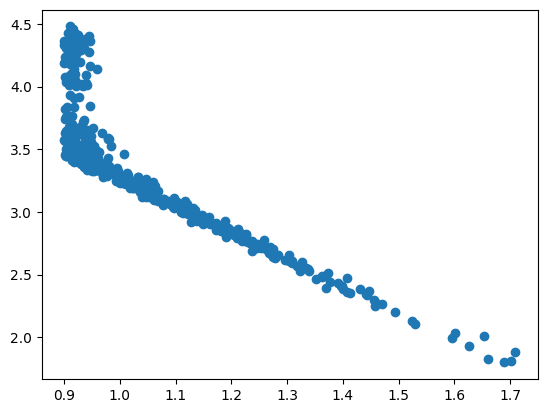

In [49]:
g = d[d.log_mean_c2c_nn_dist > 0.9]
plt.scatter(
    g.log_mean_c2c_nn_dist,
    g.log_n_craters_added_in_study_region
)

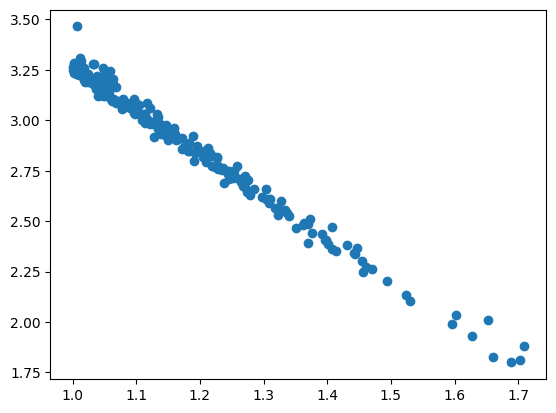

In [45]:
g = d[d.log_mean_c2c_nn_dist > 1.0]
plt.scatter(
    g.log_mean_c2c_nn_dist,
    g.log_n_craters_added_in_study_region
)

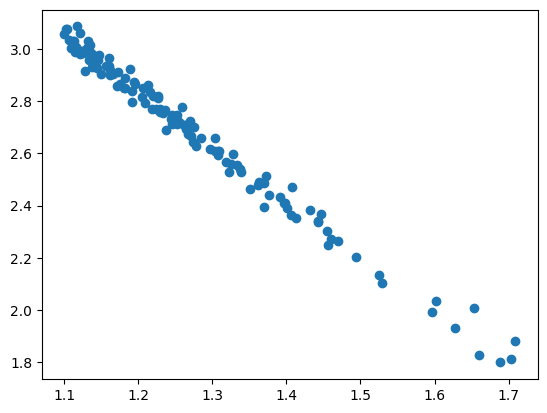

In [46]:
g = d[d.log_mean_c2c_nn_dist > 1.1]
plt.scatter(
    g.log_mean_c2c_nn_dist,
    g.log_n_craters_added_in_study_region
)

In [91]:
def detrend_data(data: DataFrame,
                 min_slope: float,
                 max_slope: float,
                 min_log_mean_nn_dist: float,
                 max_log_mean_nn_dist: float) -> DataFrame:
    data.createOrReplaceTempView("data")
    
    query = f"""
    SELECT
        log_mean_c2c_nn_dist,
        log_n_craters_added_in_study_region
    FROM
        data
    WHERE
        slope BETWEEN {min_slope} AND {max_slope}
        AND log_mean_c2c_nn_dist BETWEEN {min_log_mean_nn_dist} AND {max_log_mean_nn_dist}    
    """
    filtered = spark.sql(query)

    assembler = VectorAssembler(
        inputCols=["log_mean_c2c_nn_dist"],
        outputCol="features"
    )
    train_df = assembler.transform(filtered)
    
    model = LinearRegression(labelCol="log_n_craters_added_in_study_region", predictionCol="prediction", regParam=0.1, maxIter=1000, tol=1e-8).fit(train_df)
    
    return model.transform(train_df).select(
        (F.col("log_n_craters_added_in_study_region") - F.col("prediction")).alias("detrended"),
        "*"
    )


def detrend_data_using_single_regression(data: DataFrame,
                                         min_slope: float,
                                         max_slope: float,
                                         threshold_log_mean_nn_dist: float) -> Tuple[DataFrame, DataFrame]:
    data = data.select("log_mean_c2c_nn_dist", "log_n_craters_added_in_study_region", "slope")
    data.createOrReplaceTempView("data")
    
    query = f"""
    SELECT
        log_mean_c2c_nn_dist,
        log_n_craters_added_in_study_region
    FROM
        data
    WHERE
        slope BETWEEN {min_slope} AND {max_slope}
        AND log_mean_c2c_nn_dist > {threshold_log_mean_nn_dist}
    """
    filtered = spark.sql(query)

    if filtered.count() < MIN_N_SAMPLES:
        return None, None

    assembler = VectorAssembler(
        inputCols=["log_mean_c2c_nn_dist"],
        outputCol="features"
    )
    train_df = assembler.transform(filtered)
    
    model = LinearRegression(labelCol="log_n_craters_added_in_study_region", predictionCol="prediction", regParam=0.1, maxIter=1000, tol=1e-8).fit(train_df)
    print(model.coefficients)
    print(model.intercept)

    filtered_by_slope = data.where(data.slope.between(min_slope, max_slope))
    sample1_data = filtered_by_slope.where(
        filtered_by_slope.log_mean_c2c_nn_dist > threshold_log_mean_nn_dist
    )
    sample2_data = filtered_by_slope.where(
        filtered_by_slope.log_mean_c2c_nn_dist <= threshold_log_mean_nn_dist
    )

    if sample1_data.count() < MIN_N_SAMPLES or sample2_data.count() < MIN_N_SAMPLES:
        return None, None
    
    sample1 = model.transform(
        assembler.transform(
            sample1_data
        )
    ).select(
        (F.col("log_n_craters_added_in_study_region") - F.col("prediction")).alias("detrended"),
        "*"
    )
    sample2 = model.transform(
        assembler.transform(
            sample2_data
        )
    ).select(
        (F.col("log_n_craters_added_in_study_region") - F.col("prediction")).alias("detrended"),
        "*"
    )

    return sample1, sample2

In [5]:
def calculate_var_and_df(sample: DataFrame, col_name: str) -> Tuple[float, int]:
    cnt = sample.count()
    calc = sample.sample(min(1.0, MIN_N_SAMPLES / cnt)).select(
        F.variance(col_name).alias("variance"),
        (F.count("*") - 1).alias("df")
    ).collect()
    row = calc[0]
    return row.variance, row.df


def calculate_f_test_p_value(
    sample1: DataFrame,
    sample2: DataFrame,
    col_name: str
) -> float:
    N_RESAMPLES = 3

    result = 0

    for _ in range(N_RESAMPLES):
        sample1_var, sample1_df = calculate_var_and_df(sample1, col_name)
        sample2_var, sample2_df = calculate_var_and_df(sample2, col_name)
        
        numer, numer_df, denom, denom_df = (sample1_var, sample1_df, sample2_var, sample2_df) if sample1_var > sample2_var else (sample2_var, sample2_df, sample1_var, sample1_df)
        result += 1 - stats.f.cdf(numer / denom, numer_df, denom_df)
        print(f"Var: {numer:.4f} / {denom:.4f}")

    return result / N_RESAMPLES


def calculate_f_value(
    sample1: DataFrame,
    sample2: DataFrame,
    col_name: str
) -> float:
    N_RESAMPLES = 3

    result = 0

    for _ in range(N_RESAMPLES):
        sample1_var, sample1_df = calculate_var_and_df(sample1, col_name)
        sample2_var, sample2_df = calculate_var_and_df(sample2, col_name)  
        
        numer, numer_df, denom, denom_df = (sample1_var, sample1_df, sample2_var, sample2_df) if sample1_var > sample2_var else (sample2_var, sample2_df, sample1_var, sample1_df)
        print(f"Var: {numer:.4f} / {denom:.4f}")
        result += numer / denom

    return result / N_RESAMPLES


def calculate_ci(sample: DataFrame, col_name: str) -> Tuple[float, int]:
    calc = sample.select(
        (F.percentile_approx(col_name, 0.95) - F.percentile_approx(col_name, 0.05)).alias("ci_width")
    ).collect()
    return calc[0].ci_width
    

def calculate_ci_width_ratio(
    sample1: DataFrame,
    sample2: DataFrame,
    col_name: str
) -> float:  
    sample1_width = calculate_ci(sample1, col_name)
    sample2_width = calculate_ci(sample2, col_name)  
    
    numer, denom = (sample1_width, sample2_width) if sample1_width > sample2_width else (sample2_width, sample1_width)

    return numer / denom

In [6]:
def objective_function(
    data: DataFrame,
    min_slope: float,
    max_slope: float,
    threshold_log_mean_nn_dist: float
) -> float:
    print("Sample 1...")
    sample1 = detrend_data(
        data,
        min_slope,
        max_slope,
        -100.0,
        threshold_log_mean_nn_dist
    )

    print("Sample 1...")
    sample2 = detrend_data(
        data,
        min_slope,
        max_slope,
        threshold_log_mean_nn_dist,
        100.0
    )

    # return calculate_ci_width_ratio(sample1, sample2, "detrended")
    # return calculate_f_value(sample1, sample2, "detrended")
    return calculate_f_test_p_value(sample1, sample2, "detrended")   


def create_objective_function_single_regression(
    data: DataFrame,
    min_slope: float,
    max_slope: float
) -> float:
    data = data.where(F.col("slope").between(min_slope, max_slope)).cache()
    
    def objective_function(args):
        threshold_log_mean_nn_dist = args["threshold_log_mean_nn_dist"]

        
        sample1, sample2 = detrend_data_using_alternate_slope_calc(
            data,
            min_slope,
            max_slope,
            threshold_log_mean_nn_dist
        )

        if sample1 is None or sample2 is None:
            result = 0
        else: 
            # result = calculate_f_test_p_value(sample1, sample2, "detrended")
            result = calculate_f_value(sample1, sample2, "detrended")
            
        print(f"{threshold_log_mean_nn_dist:.3f}, {result}")

        return {
            "loss": -result,
            "params": args,
            "status": STATUS_OK
        }

    return objective_function

In [87]:
def detrend_data_using_single_regression_narrow_window(data: DataFrame,
                                                       min_slope: float,
                                                       max_slope: float,
                                                       threshold_log_mean_nn_dist: float,
                                                       log_mean_nn_dist_window_width: float) -> DataFrame:
    data = data.select("log_mean_c2c_nn_dist", "log_n_craters_added_in_study_region", "slope")
    data.createOrReplaceTempView("data")
    
    query = f"""
    SELECT
        log_mean_c2c_nn_dist,
        log_n_craters_added_in_study_region
    FROM
        data
    WHERE
        slope BETWEEN {min_slope} AND {max_slope}
        AND log_mean_c2c_nn_dist > {threshold_log_mean_nn_dist}
    """
    filtered = spark.sql(query)

    if filtered.count() < MIN_N_SAMPLES:
        return None, None

    assembler = VectorAssembler(
        inputCols=["log_mean_c2c_nn_dist"],
        outputCol="features"
    )
    train_df = assembler.transform(filtered)
    
    model = LinearRegression(labelCol="log_n_craters_added_in_study_region", predictionCol="prediction", regParam=0.1, maxIter=1000, tol=1e-8).fit(train_df)
    print(model.coefficients)

    sample1_data = data.where(data.log_mean_c2c_nn_dist.between(threshold_log_mean_nn_dist - log_mean_nn_dist_window_width, threshold_log_mean_nn_dist))
    sample2_data = data.where(data.log_mean_c2c_nn_dist.between(threshold_log_mean_nn_dist, threshold_log_mean_nn_dist + log_mean_nn_dist_window_width))

    if sample1_data.count() < MIN_N_SAMPLES or sample2_data.count() < MIN_N_SAMPLES:
        return None, None
    
    sample1 = model.transform(
        assembler.transform(
            sample1_data
        )
    ).select(
        (F.col("log_n_craters_added_in_study_region") - F.col("prediction")).alias("detrended"),
        "*"
    )
    sample2 = model.transform(
        assembler.transform(
            sample2_data
        )
    ).select(
        (F.col("log_n_craters_added_in_study_region") - F.col("prediction")).alias("detrended"),
        "*"
    )

    return sample1, sample2
    

def create_objective_function_single_regression_narrow_windows(
    data: DataFrame,
    min_slope: float,
    max_slope: float,
    log_mean_nn_dist_window_width: float
) -> float:
    data = data.where(F.col("slope").between(min_slope, max_slope)).cache()
    
    def objective_function(args):
        threshold_log_mean_nn_dist = args["threshold_log_mean_nn_dist"]
        print(f"Trying threshold = {threshold_log_mean_nn_dist:.4f}")
        
        sample1, sample2 = detrend_data_using_single_regression_narrow_window(
            data,
            min_slope,
            max_slope,
            threshold_log_mean_nn_dist,
            log_mean_nn_dist_window_width
        )

        if sample1 is None or sample2 is None:
            result = 0.0
        else: 
            # result = -calculate_f_test_p_value(sample1, sample2, "detrended")
            result = calculate_f_value(sample1, sample2, "detrended")
            
        print(f"{threshold_log_mean_nn_dist:.3f}, {result}")

        return {
            "loss": -result,
            "params": args,
            "status": STATUS_OK
        }

    return objective_function

In [8]:
def calculate_ci_width_ratio_sampled(
    sample1: DataFrame,
    sample2: DataFrame,
    col_name: str
) -> float:
    sample1_width = calculate_ci(sample1, col_name)
    sample2_width = calculate_ci(sample2, col_name)  
    
    numer, denom = (sample1_width, sample2_width) if sample1_width > sample2_width else (sample2_width, sample1_width)

    print(f"CI width: {numer:.4f} / {denom:.4f}")
    return numer / denom
    

def create_objective_function_single_regression_narrow_windows_ci_width(
    data: DataFrame,
    min_slope: float,
    max_slope: float
) -> float:
    data = data.where(F.col("slope").between(min_slope, max_slope))
    max_log_mean_nn_dist = data.select(F.percentile_approx("log_mean_c2c_nn_dist", 0.98).alias("result")).collect()[0].result
    data = data.where(F.col("log_mean_c2c_nn_dist") < max_log_mean_nn_dist).cache()

    max_log_mean_nn_dist = data.select(F.percentile_approx("log_mean_c2c_nn_dist", 0.95).alias("result")).collect()[0].result
    min_log_mean_nn_dist = data.select(F.percentile_approx("log_mean_c2c_nn_dist", 0.05).alias("result")).collect()[0].result
    log_mean_nn_dist_window_width = (max_nn_dist - min_log_mean_nn_dist) / 30
    
    def objective_function(args):
        threshold_log_mean_nn_dist = args["threshold_log_mean_nn_dist"]
        print(f"Trying threshold = {threshold_log_mean_nn_dist:.4f}")
        
        sample1, sample2 = detrend_data_using_single_regression_narrow_window(
            data,
            min_slope,
            max_slope,
            threshold_log_mean_nn_dist,
            log_mean_nn_dist_window_width
        )

        if sample1 is None or sample2 is None:
            result = 0.0
        else: 
            # result = -calculate_f_test_p_value(sample1, sample2, "detrended")
            # result = calculate_f_value(sample1, sample2, "detrended")
            result = calculate_ci_width_ratio_sampled(sample1, sample2, "detrended")
            
        print(f"{threshold_log_mean_nn_dist:.3f}, {result}")

        return {
            "loss": -result,
            "params": args,
            "status": STATUS_OK
        }

    return objective_function

## Detrend and check ratio outside 95% CI

In [92]:
sample1, sample2 = detrend_data_using_single_regression(data_with_configs.sample(0.25), 2.1, 2.2, 1.1)

[-1.555463530704156]
4.655295810130562


In [81]:
df1 = sample1.toPandas()
df2 = sample2.toPandas()

In [82]:
combined = pd.concat([df1, df2], axis=0)
combined

,detrended,log_mean_c2c_nn_dist,log_n_craters_added_in_study_region,slope,features,prediction
0,-0.125511,1.600222,2.045323,2.151335,[1.6002218213945372],2.170834
1,0.017053,1.283718,2.680336,2.151335,[1.2837183342120562],2.663283
2,-0.035333,1.439476,2.385606,2.192030,[1.4394756850668966],2.420939
3,-0.019237,1.250097,2.696356,2.197711,[1.2500973527712744],2.715594
4,0.038055,1.159333,2.894870,2.197711,[1.159332904208921],2.856815
...,...,...,...,...,...,...
46533,1.329328,0.634084,5.003379,2.179378,[0.6340844846094892],3.674051
46534,1.330459,0.632423,5.007095,2.179378,[0.6324232106067994],3.676635
46535,1.332111,0.632025,5.009366,2.179378,[0.6320249471054267],3.677255
46536,1.277788,0.603019,5.000174,2.108569,[0.6030191338674774],3.722385


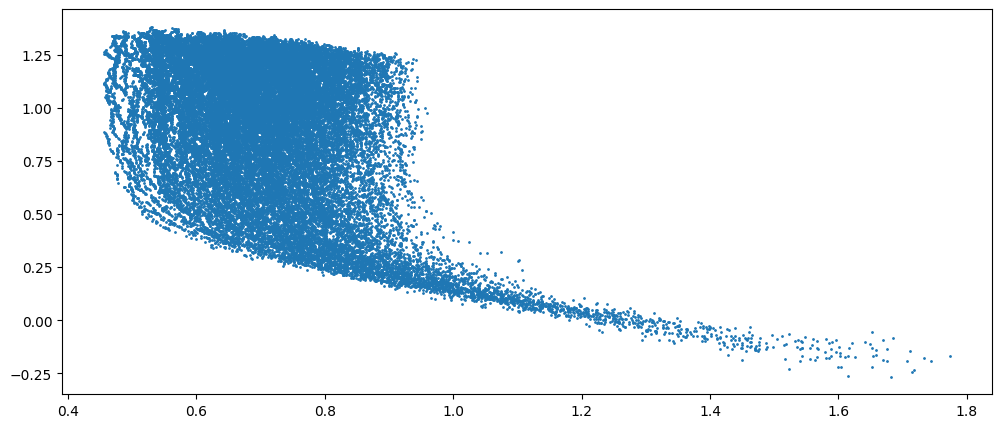

In [83]:
plt.figure(figsize=(12,5))
plt.scatter(
    combined.log_mean_c2c_nn_dist,
    combined.detrended,
    s=1
)


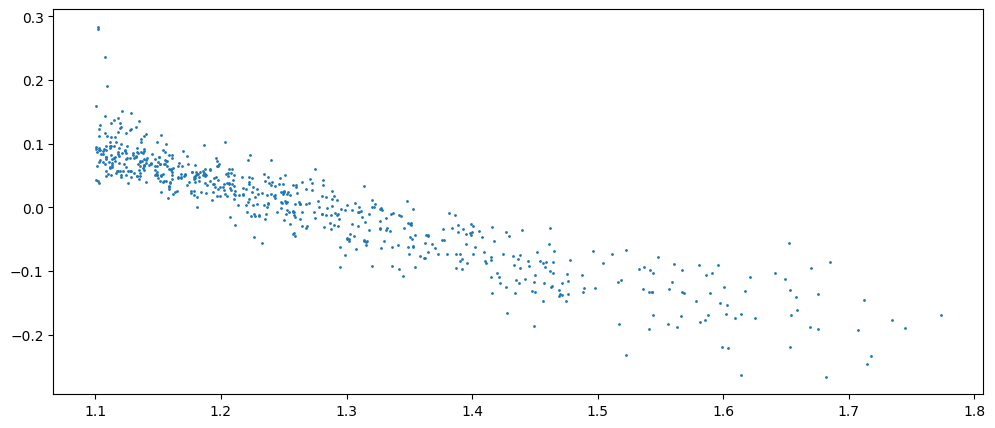

In [86]:
plt.figure(figsize=(12,5))
plt.scatter(
    df1.log_mean_c2c_nn_dist,
    df1.detrended,
    s=1
)

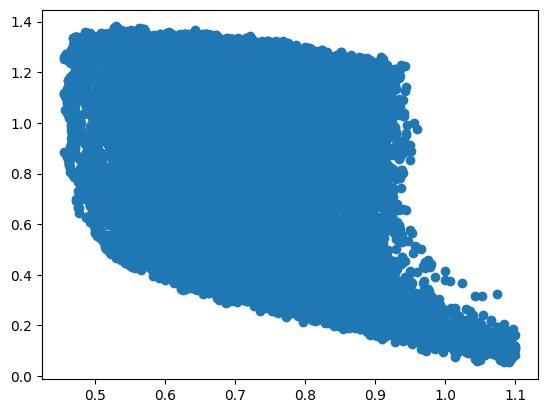

In [85]:
plt.scatter(
    df2.log_mean_c2c_nn_dist,
    df2.detrended
)

In [26]:
trials = Trials()
space = {
    "threshold_log_mean_nn_dist": hp.uniform("threshold_log_mean_nn_dist", min_nn_dist, max_nn_dist),
}

best = fmin(create_objective_function_single_regression_narrow_windows_ci_width(data_with_configs, 2.1, 2.2),
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=50)
best

Trying threshold = 0.6803                                                                                                                                                                                                                                                              
  0%|                                                                                                                                                                                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

CI width: 0.8655 / 0.8149                                                                                                                                                                                                                                                              
0.680, 1.0621940272721557                                                                                                                                                                                                                                                              
Trying threshold = 0.8361                                                                                                                                                                                                                                                              
  2%|████▏                                                                                                                                                      

CI width: 0.9897 / 0.9647                                                                                                                                                                                                                                                              
0.836, 1.0258419747791876                                                                                                                                                                                                                                                              
Trying threshold = 0.6237                                                                                                                                                                                                                                                              
  4%|████████▎                                                                                                                                                  

CI width: 0.8059 / 0.7898                                                                                                                                                                                                                                                              
0.624, 1.020365898061868                                                                                                                                                                                                                                                               
Trying threshold = 0.5525                                                                                                                                                                                                                                                              
  6%|████████████▍                                                                                                                                              

CI width: 0.7634 / 0.7022                                                                                                                                                                                                                                                              
0.553, 1.0872042294188864                                                                                                                                                                                                                                                              
Trying threshold = 0.5498                                                                                                                                                                                                                                                              
  8%|████████████████▋                                                                                                                                          

CI width: 0.7573 / 0.7028                                                                                                                                                                                                                                                              
0.550, 1.0775153967950026                                                                                                                                                                                                                                                              
Trying threshold = 1.9090                                                                                                                                                                                                                                                              
 10%|████████████████████▊                                                                                                                                      

1.909, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.6569                                                                                                                                                                                                                                                              
1.657, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.2095                                                                                                                                       

CI width: 0.6971 / 0.5010                                                                                                                                                                                                                                                              
0.477, 1.3912485126447582                                                                                                                                                                                                                                                              
Trying threshold = 1.5408                                                                                                                                                                                                                                                              
1.541, 0.0                                                                                                                                                      

CI width: 0.9002 / 0.8616                                                                                                                                                                                                                                                              
0.722, 1.0447532778983688                                                                                                                                                                                                                                                              
Trying threshold = 1.4197                                                                                                                                                                                                                                                              
 36%|██████████████████████████████████████████████████████████████████████████▌                                                                                

1.420, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.8445                                                                                                                                                                                                                                                              
1.845, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.8768                                                                                                                                       

CI width: 1.0138 / 0.9853                                                                                                                                                                                                                                                              
0.877, 1.0289470241935392                                                                                                                                                                                                                                                              
Trying threshold = 1.0620                                                                                                                                                                                                                                                              
 42%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    

1.062, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.4602                                                                                                                                                                                                                                                              
 44%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 22/50 [02:08<01:26,  3.10s/trial, best loss: -2.4511848588012177]

CI width: 0.6351 / 0.3987                                                                                                                                                                                                                                                              
0.460, 1.5928732753200894                                                                                                                                                                                                                                                              
Trying threshold = 0.8981                                                                                                                                                                                                                                                              
 46%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                           

CI width: 1.0149 / 1.0115                                                                                                                                                                                                                                                              
0.898, 1.0034294965863282                                                                                                                                                                                                                                                              
Trying threshold = 1.1815                                                                                                                                                                                                                                                              
 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       

1.181, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.7770                                                                                                                                                                                                                                                              
 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 25/50 [02:31<02:00,  4.81s/trial, best loss: -2.4511848588012177]

CI width: 0.9521 / 0.9122                                                                                                                                                                                                                                                              
0.777, 1.043777513751885                                                                                                                                                                                                                                                               
Trying threshold = 0.9887                                                                                                                                                                                                                                                              
 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               

CI width: 0.4090 / 0.1641                                                                                                                                                                                                                                                              
0.989, 2.491573334935772                                                                                                                                                                                                                                                               
Trying threshold = 1.0141                                                                                                                                                                                                                                                              
CI width: 0.2040 / 0.1373                                                                                                                                       

CI width: 0.8296 / 0.7987                                                                                                                                                                                                                                                              
0.648, 1.0386110486516933                                                                                                                                                                                                                                                              
Trying threshold = 0.9461                                                                                                                                                                                                                                                              
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  

CI width: 1.0097 / 0.3075                                                                                                                                                                                                                                                              
0.946, 3.2838174631299415                                                                                                                                                                                                                                                              
Trying threshold = 0.7521                                                                                                                                                                                                                                                              
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              

CI width: 0.9262 / 0.8830                                                                                                                                                                                                                                                              
0.752, 1.0489333392585654                                                                                                                                                                                                                                                              
Trying threshold = 0.8421                                                                                                                                                                                                                                                              
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          

CI width: 1.0005 / 0.9703                                                                                                                                                                                                                                                              
0.842, 1.031160151376357                                                                                                                                                                                                                                                               
Trying threshold = 1.2689                                                                                                                                                                                                                                                              
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      

1.269, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.6234                                                                                                                                                                                                                                                              
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 37/50 [03:35<01:11,  5.49s/trial, best loss: -3.2838174631299415]

CI width: 0.8055 / 0.7902                                                                                                                                                                                                                                                              
0.623, 1.0193320611079209                                                                                                                                                                                                                                                              
Trying threshold = 0.5688                                                                                                                                                                                                                                                              
 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

CI width: 0.7830 / 0.7165                                                                                                                                                                                                                                                              
0.569, 1.0927392027360812                                                                                                                                                                                                                                                              
Trying threshold = 0.9445                                                                                                                                                                                                                                                              
 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

CI width: 1.0112 / 0.3387                                                                                                                                                                                                                                                              
0.944, 2.985930726032911                                                                                                                                                                                                                                                               
Trying threshold = 1.0955                                                                                                                                                                                                                                                              
1.096, 0.0                                                                                                                                                      

CI width: 0.9642 / 0.9265                                                                                                                                                                                                                                                              
0.793, 1.0406677980982784                                                                                                                                                                                                                                                              
Trying threshold = 0.6942                                                                                                                                                                                                                                                              
 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

CI width: 0.8742 / 0.8284                                                                                                                                                                                                                                                              
0.694, 1.0551823895930545                                                                                                                                                                                                                                                              
Trying threshold = 1.1365                                                                                                                                                                                                                                                              
 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

1.136, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.9339                                                                                                                                                                                                                                                              
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 44/50 [04:45<00:44,  7.44s/trial, best loss: -3.2838174631299415]

CI width: 1.0032 / 0.8076                                                                                                                                                                                                                                                              
0.934, 1.2421784773184281                                                                                                                                                                                                                                                              
Trying threshold = 0.5253                                                                                                                                                                                                                                                              
 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

CI width: 0.7247 / 0.7055                                                                                                                                                                                                                                                              
0.525, 1.0272455762451327                                                                                                                                                                                                                                                              
Trying threshold = 1.3337                                                                                                                                                                                                                                                              
 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

1.334, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.5323                                                                                                                                                                                                                                                              
1.532, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.4648                                                                                                                                       

CI width: 0.9799 / 0.9571                                                                                                                                                                                                                                                              
0.824, 1.0238454061054019                                                                                                                                                                                                                                                              
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:17<00:00,  6.35s/trial, best loss: -3.2838174631299415]


{'threshold_log_mean_nn_dist': 0.9461039348101453}

In [27]:
trials = Trials()
space = {
    "threshold_log_mean_nn_dist": hp.uniform("threshold_log_mean_nn_dist", min_nn_dist, max_nn_dist),
}

best = fmin(create_objective_function_single_regression_narrow_windows_ci_width(data_with_configs, 1.5, 1.6),
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=50)
best

Trying threshold = 0.9596                                                                                                                                                                                                                                                              
  0%|                                                                                                                                                                                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

CI width: 0.7800 / 0.7501                                                                                                                                                                                                                                                              
0.960, 1.0398163590438592                                                                                                                                                                                                                                                              
Trying threshold = 1.1541                                                                                                                                                                                                                                                              
CI width: 0.3365 / 0.2059                                                                                                                                       

CI width: 0.5302 / 0.5038                                                                                                                                                                                                                                                              
0.729, 1.0523256282104718                                                                                                                                                                                                                                                              
Trying threshold = 1.4545                                                                                                                                                                                                                                                              
1.454, 0.0                                                                                                                                                      

CI width: 0.7729 / 0.7316                                                                                                                                                                                                                                                              
0.940, 1.0564565263490422                                                                                                                                                                                                                                                              
Trying threshold = 1.1693                                                                                                                                                                                                                                                              
 20%|█████████████████████████████████████████▍                                                                                                                 

CI width: 0.2533 / 0.1852                                                                                                                                                                                                                                                              
1.169, 1.3680787744426404                                                                                                                                                                                                                                                              
Trying threshold = 0.5836                                                                                                                                                                                                                                                              
 22%|█████████████████████████████████████████████▌                                                                                                             

0.584, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.5529                                                                                                                                                                                                                                                              
1.553, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.4434                                                                                                                                       

0.491, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.1855                                                                                                                                                                                                                                                              
CI width: 0.2207 / 0.1746                                                                                                                                                                                                                                                              
1.186, 1.2637799522681865                                                                                                                                       

CI width: 0.7802 / 0.7522                                                                                                                                                                                                                                                              
0.961, 1.037281561615261                                                                                                                                                                                                                                                               
Trying threshold = 1.0619                                                                                                                                                                                                                                                              
 40%|██████████████████████████████████████████████████████████████████████████████████▊                                                                        

CI width: 0.7206 / 0.5992                                                                                                                                                                                                                                                              
1.062, 1.2026725971627594                                                                                                                                                                                                                                                              
Trying threshold = 0.7777                                                                                                                                                                                                                                                              
 42%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    

CI width: 0.6336 / 0.5463                                                                                                                                                                                                                                                              
0.778, 1.159851115856262                                                                                                                                                                                                                                                               
Trying threshold = 1.3518                                                                                                                                                                                                                                                              
 44%|███████████████████████████████████████████████████████████████████████████████████████████                                                                

1.352, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.9151                                                                                                                                                                                                                                                              
1.915, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.0712                                                                                                                                       

CI width: 0.6434 / 0.5850                                                                                                                                                                                                                                                              
0.793, 1.0998787723840848                                                                                                                                                                                                                                                              
Trying threshold = 1.3151                                                                                                                                                                                                                                                              
 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               

1.315, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.0567                                                                                                                                                                                                                                                              
CI width: 0.7331 / 0.6231                                                                                                                                                                                                                                                              
1.057, 1.1765991558603164                                                                                                                                       

CI width: 0.7247 / 0.6935                                                                                                                                                                                                                                                              
0.893, 1.0450672978348146                                                                                                                                                                                                                                                              
Trying threshold = 1.0950                                                                                                                                                                                                                                                              
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   

CI width: 0.6268 / 0.4596                                                                                                                                                                                                                                                              
1.095, 1.3637476839622273                                                                                                                                                                                                                                                              
Trying threshold = 0.6101                                                                                                                                                                                                                                                              
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              

0.610, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.1781                                                                                                                                                                                                                                                              
CI width: 0.2340 / 0.1774                                                                                                                                                                                                                                                              
1.178, 1.3192415404041675                                                                                                                                       

CI width: 0.7080 / 0.6680                                                                                                                                                                                                                                                              
0.869, 1.0598956923856664                                                                                                                                                                                                                                                              
Trying threshold = 1.6308                                                                                                                                                                                                                                                              
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              

1.631, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.9138                                                                                                                                                                                                                                                              
1.914, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.6561                                                                                                                                       

CI width: 0.3755 / 0.0063                                                                                                                                                                                                                                                              
0.656, 59.14725986723666                                                                                                                                                                                                                                                               
Trying threshold = 0.6840                                                                                                                                                                                                                                                              
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ 

CI width: 0.4939 / 0.3214                                                                                                                                                                                                                                                              
0.684, 1.536581819980459                                                                                                                                                                                                                                                               
Trying threshold = 0.5217                                                                                                                                                                                                                                                              
 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

0.522, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.6882                                                                                                                                                                                                                                                              
 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 39/50 [02:06<00:59,  5.38s/trial, best loss: -59.14725986723666]

CI width: 0.5017 / 0.3369                                                                                                                                                                                                                                                              
0.688, 1.489506055414288                                                                                                                                                                                                                                                               
Trying threshold = 0.9970                                                                                                                                                                                                                                                              
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

CI width: 0.7811 / 0.7600                                                                                                                                                                                                                                                              
0.997, 1.0276655892566895                                                                                                                                                                                                                                                              
Trying threshold = 0.4593                                                                                                                                                                                                                                                              
 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

0.459, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.8461                                                                                                                                                                                                                                                              
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 42/50 [02:24<00:45,  5.71s/trial, best loss: -59.14725986723666]

CI width: 0.6844 / 0.6514                                                                                                                                                                                                                                                              
0.846, 1.0505986201785464                                                                                                                                                                                                                                                              
Trying threshold = 1.2722                                                                                                                                                                                                                                                              
 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

1.272, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.4397                                                                                                                                                                                                                                                              
1.440, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.5797                                                                                                                                       

0.580, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.6426                                                                                                                                                                                                                                                              
 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 46/50 [02:39<00:16,  4.15s/trial, best loss: -59.14725986723666]

1.643, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.8578                                                                                                                                                                                                                                                              
1.858, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.6446                                                                                                                                       

0.645, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.7413                                                                                                                                                                                                                                                              
 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 49/50 [02:46<00:03,  3.40s/trial, best loss: -59.14725986723666]

CI width: 0.5590 / 0.5211                                                                                                                                                                                                                                                              
0.741, 1.0728048024017423                                                                                                                                                                                                                                                              
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:54<00:00,  3.48s/trial, best loss: -59.14725986723666]


{'threshold_log_mean_nn_dist': 0.6561326518227031}

In [28]:
trials = Trials()
space = {
    "threshold_log_mean_nn_dist": hp.uniform("threshold_log_mean_nn_dist", min_nn_dist, max_nn_dist),
}

best = fmin(create_objective_function_single_regression_narrow_windows_ci_width(data_with_configs, 2.6, 2.7),
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=50)
best

Trying threshold = 1.7405                                                                                                                                                                                                                                                              
  0%|                                                                                                                                                                                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

1.740, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.6187                                                                                                                                                                                                                                                              
  2%|████▍                                                                                                                                                                                                                          | 1/50 [00:00<00:14,  3.41trial/s, best loss: -0.0]

CI width: 0.8447 / 0.7626                                                                                                                                                                                                                                                              
0.619, 1.1076058550915204                                                                                                                                                                                                                                                              
Trying threshold = 0.7056                                                                                                                                                                                                                                                              
  4%|████████▎                                                                                                                                                  

CI width: 0.9148 / 0.8515                                                                                                                                                                                                                                                              
0.706, 1.0743539918018108                                                                                                                                                                                                                                                              
Trying threshold = 1.7246                                                                                                                                                                                                                                                              
  6%|████████████▍                                                                                                                                              

1.725, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.7944                                                                                                                                                                                                                                                              
  8%|████████████████▋                                                                                                                                                                                               | 4/50 [00:28<05:02,  6.57s/trial, best loss: -1.1076058550915204]

CI width: 0.9612 / 0.9152                                                                                                                                                                                                                                                              
0.794, 1.0502733032566152                                                                                                                                                                                                                                                              
Trying threshold = 1.8099                                                                                                                                                                                                                                                              
 10%|████████████████████▊                                                                                                                                      

1.810, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.9490                                                                                                                                                                                                                                                              
 12%|████████████████████████▉                                                                                                                                                                                       | 6/50 [00:38<03:51,  5.27s/trial, best loss: -1.1076058550915204]

CI width: 1.0391 / 1.0152                                                                                                                                                                                                                                                              
0.949, 1.023521230618414                                                                                                                                                                                                                                                               
Trying threshold = 0.4597                                                                                                                                                                                                                                                              
 14%|█████████████████████████████                                                                                                                              

0.460, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.8680                                                                                                                                                                                                                                                              
1.868, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.9588                                                                                                                                       

CI width: 1.0502 / 1.0267                                                                                                                                                                                                                                                              
0.959, 1.022877846548316                                                                                                                                                                                                                                                               
Trying threshold = 1.9038                                                                                                                                                                                                                                                              
1.904, 0.0                                                                                                                                                      

CI width: 0.7553 / 0.7047                                                                                                                                                                                                                                                              
0.506, 1.0718144355479018                                                                                                                                                                                                                                                              
Trying threshold = 0.6569                                                                                                                                                                                                                                                              
 42%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    

CI width: 0.8554 / 0.8396                                                                                                                                                                                                                                                              
0.657, 1.0187965465655255                                                                                                                                                                                                                                                              
Trying threshold = 0.6418                                                                                                                                                                                                                                                              
 44%|███████████████████████████████████████████████████████████████████████████████████████████                                                                

CI width: 0.8615 / 0.8145                                                                                                                                                                                                                                                              
0.642, 1.0577053337432483                                                                                                                                                                                                                                                              
Trying threshold = 0.7629                                                                                                                                                                                                                                                              
 46%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                           

CI width: 0.9228 / 0.9225                                                                                                                                                                                                                                                              
0.763, 1.000283526893413                                                                                                                                                                                                                                                               
Trying threshold = 1.3226                                                                                                                                                                                                                                                              
 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       

1.323, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.5635                                                                                                                                                                                                                                                              
 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 25/50 [01:58<02:54,  7.00s/trial, best loss: -1.1076058550915204]

CI width: 0.7404 / 0.7365                                                                                                                                                                                                                                                              
0.564, 1.0053692892061041                                                                                                                                                                                                                                                              
Trying threshold = 0.8059                                                                                                                                                                                                                                                              
 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               

CI width: 0.9637 / 0.9202                                                                                                                                                                                                                                                              
0.806, 1.0472793967600857                                                                                                                                                                                                                                                              
Trying threshold = 1.4224                                                                                                                                                                                                                                                              
 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           

1.422, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.1316                                                                                                                                                                                                                                                              
1.132, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.7113                                                                                                                                       

CI width: 0.9186 / 0.8607                                                                                                                                                                                                                                                              
0.711, 1.0672137751943782                                                                                                                                                                                                                                                              
Trying threshold = 0.5784                                                                                                                                                                                                                                                              
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              

CI width: 0.7738 / 0.7269                                                                                                                                                                                                                                                              
0.578, 1.064588347654709                                                                                                                                                                                                                                                               
Trying threshold = 0.9203                                                                                                                                                                                                                                                              
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          

CI width: 1.0146 / 1.0013                                                                                                                                                                                                                                                              
0.920, 1.0133017372207072                                                                                                                                                                                                                                                              
Trying threshold = 0.8626                                                                                                                                                                                                                                                              
 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      

CI width: 0.9889 / 0.9705                                                                                                                                                                                                                                                              
0.863, 1.019026372257292                                                                                                                                                                                                                                                               
Trying threshold = 1.0840                                                                                                                                                                                                                                                              
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  

1.084, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.4733                                                                                                                                                                                                                                                              
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 34/50 [03:02<01:28,  5.56s/trial, best loss: -1.1076058550915204]

0.473, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.8478                                                                                                                                                                                                                                                              
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 35/50 [03:15<01:54,  7.61s/trial, best loss: -1.1076058550915204]

CI width: 0.9850 / 0.9616                                                                                                                                                                                                                                                              
0.848, 1.0243034576881507                                                                                                                                                                                                                                                              
Trying threshold = 0.7286                                                                                                                                                                                                                                                              
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      

CI width: 0.9173 / 0.8815                                                                                                                                                                                                                                                              
0.729, 1.040593806996368                                                                                                                                                                                                                                                               
Trying threshold = 1.2391                                                                                                                                                                                                                                                              
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ 

1.239, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.0185                                                                                                                                                                                                                                                              
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 38/50 [03:35<01:17,  6.42s/trial, best loss: -1.1076058550915204]

CI width: 1.0121 / 0.8785                                                                                                                                                                                                                                                              
1.019, 1.1519741940431973                                                                                                                                                                                                                                                              
Trying threshold = 1.3695                                                                                                                                                                                                                                                              
1.370, 0.0                                                                                                                                                      

CI width: 1.0049 / 0.9877                                                                                                                                                                                                                                                              
0.900, 1.0174827763274843                                                                                                                                                                                                                                                              
Trying threshold = 1.2437                                                                                                                                                                                                                                                              
 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

1.244, 0.0                                                                                                                                                                                                                                                                             
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:58<00:00,  4.76s/trial, best loss: -6.5427846691642895]


{'threshold_log_mean_nn_dist': 1.076377772104497}

In [29]:
trials = Trials()
space = {
    "threshold_log_mean_nn_dist": hp.uniform("threshold_log_mean_nn_dist", min_nn_dist, max_nn_dist),
}

best = fmin(create_objective_function_single_regression_narrow_windows_ci_width(data_with_configs, 1.2, 1.3),
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=50)
best

Trying threshold = 1.1344                                                                                                                                                                                                                                                              
  0%|                                                                                                                                                                                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

CI width: 0.7121 / 0.7020                                                                                                                                                                                                                                                              
1.134, 1.0143930944766784                                                                                                                                                                                                                                                              
Trying threshold = 1.7259                                                                                                                                                                                                                                                              
1.726, 0.0                                                                                                                                                      

0.793, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.9235                                                                                                                                                                                                                                                              
1.924, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.0971                                                                                                                                       

CI width: 0.7002 / 0.6707                                                                                                                                                                                                                                                              
1.097, 1.044059360285419                                                                                                                                                                                                                                                               
Trying threshold = 0.5143                                                                                                                                                                                                                                                              
 10%|████████████████████▉                                                                                                                                      

0.514, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.2742                                                                                                                                                                                                                                                              
CI width: 0.6967 / 0.6442                                                                                                                                                                                                                                                              
1.274, 1.0814018642324996                                                                                                                                       

0.757, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.5563                                                                                                                                                                                                                                                              
 16%|█████████████████████████████████▎                                                                                                                                                                              | 8/50 [00:19<01:52,  2.69s/trial, best loss: -1.0814018642324996]

0.556, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.7381                                                                                                                                                                                                                                                              
 18%|█████████████████████████████████████▍                                                                                                                                                                          | 9/50 [00:22<01:55,  2.82s/trial, best loss: -1.0814018642324996]

0.738, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.7813                                                                                                                                                                                                                                                              
 20%|█████████████████████████████████████████▍                                                                                                                                                                     | 10/50 [00:25<01:56,  2.91s/trial, best loss: -1.0814018642324996]

0.781, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.6479                                                                                                                                                                                                                                                              
1.648, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 0.9533                                                                                                                                       

CI width: 0.5931 / 0.5356                                                                                                                                                                                                                                                              
0.953, 1.1074090042247533                                                                                                                                                                                                                                                              
Trying threshold = 0.5859                                                                                                                                                                                                                                                              
 26%|█████████████████████████████████████████████████████▊                                                                                                     

0.586, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.4291                                                                                                                                                                                                                                                              
CI width: 0.2048 / 0.2016                                                                                                                                                                                                                                                              
1.429, 1.0161643462405998                                                                                                                                       

CI width: 0.6470 / 0.6189                                                                                                                                                                                                                                                              
1.021, 1.0453838436947485                                                                                                                                                                                                                                                              
Trying threshold = 1.7161                                                                                                                                                                                                                                                              
1.716, 0.0                                                                                                                                                      

CI width: 0.5730 / 0.5019                                                                                                                                                                                                                                                              
0.934, 1.1416745857623716                                                                                                                                                                                                                                                              
Trying threshold = 1.4215                                                                                                                                                                                                                                                              
CI width: 0.2127 / 0.2033                                                                                                                                       

CI width: 0.5509 / 0.4911                                                                                                                                                                                                                                                              
0.925, 1.121909515116121                                                                                                                                                                                                                                                               
Trying threshold = 1.4991                                                                                                                                                                                                                                                              
1.499, 0.0                                                                                                                                                      

CI width: 0.5242 / 0.4946                                                                                                                                                                                                                                                              
0.896, 1.0599444793422552                                                                                                                                                                                                                                                              
Trying threshold = 1.1193                                                                                                                                                                                                                                                              
 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       

CI width: 0.7089 / 0.6915                                                                                                                                                                                                                                                              
1.119, 1.0251353108333892                                                                                                                                                                                                                                                              
Trying threshold = 1.3564                                                                                                                                                                                                                                                              
CI width: 0.3553 / 0.2623                                                                                                                                       

CI width: 0.6600 / 0.6429                                                                                                                                                                                                                                                              
1.048, 1.0266092516507512                                                                                                                                                                                                                                                              
Trying threshold = 1.8163                                                                                                                                                                                                                                                              
1.816, 0.0                                                                                                                                                      

0.675, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.2794                                                                                                                                                                                                                                                              
CI width: 0.6932 / 0.6140                                                                                                                                                                                                                                                              
1.279, 1.1289946749450896                                                                                                                                       

0.826, 0.0                                                                                                                                                                                                                                                                             
Trying threshold = 1.0671                                                                                                                                                                                                                                                              
 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 45/50 [01:39<00:09,  1.84s/trial, best loss: -1.651954171458098]

CI width: 0.6733 / 0.6522                                                                                                                                                                                                                                                              
1.067, 1.0323227907431702                                                                                                                                                                                                                                                              
Trying threshold = 1.8217                                                                                                                                                                                                                                                              
1.822, 0.0                                                                                                                                                      

CI width: 0.6130 / 0.5879                                                                                                                                                                                                                                                              
0.981, 1.0428448653019504                                                                                                                                                                                                                                                              
Trying threshold = 1.3310                                                                                                                                                                                                                                                              
CI width: 0.5079 / 0.3153                                                                                                                                       

{'threshold_log_mean_nn_dist': 1.333297081046845}

In [ ]:
cached = data_with_configs.where(F.col("slope").between(2.1, 2.2)).cache()
result = minimize_scalar(
    lambda x: objective_function_single_regression(cached, 2.1, 2.2, x),
    bounds=(0.5, 1.4),
    tol=1e-3
)

In [ ]:
cached = data_with_configs.where(F.col("slope").between(1.5, 1.6)).cache()
result = minimize_scalar(
    lambda x: objective_function_single_regression(cached, 1.5, 1.6, x),
    bounds=(0.5, 1.4),
    tol=1e-3
)

In [ ]:
cached = data_with_configs.where(F.col("slope").between(1.5, 1.6)).cache()
for x in range(10):
    nn_dist = 0.8 + x / 20
    print(f"{nn_dist:.3f}, {objective_function_single_regression(cached, 1.5, 1.6, nn_dist)}")

In [ ]:
cached = data_with_configs.where(F.col("slope").between(2.1, 2.2)).cache()
for x in range(30):
    nn_dist = 0.8 + x / 150
    print(f"{nn_dist:.3f}, {objective_function_single_regression(cached, 2.1, 2.2, nn_dist)}")

In [ ]:
cached = data_with_configs.where(F.col("slope").between(2.1, 2.2)).cache()
for x in range(30):
    nn_dist = 0.8 + x / 150
    print(f"{nn_dist:.3f}, {objective_function_single_regression(cached, 2.1, 2.2, nn_dist)}")

In [ ]:
for x in range(10):
    nn_dist = 0.7 + x / 20
    print(f"{nn_dist:.3f}, {objective_function(data_with_configs, 2.3, 2.4, nn_dist)}")

In [ ]:
min_slope = 2.1
max_slope = 2.2

for x in range(10):
    nn_dist = 0.7 + x / 20
    sample = detrend_data(
        data_with_configs,
        min_slope,
        max_slope,
        -100.0,
        nn_dist
    )
    print(f"{nn_dist:.3f}, {calculate_var_and_df(sample, 'detrended')[0]}")

In [ ]:
min_slope = 2.1
max_slope = 2.2

for x in range(10):
    nn_dist = 0.7 + x / 20
    sample = detrend_data(
        data_with_configs,
        min_slope,
        max_slope,
        nn_dist,
        10.0
    )
    print(f"{nn_dist:.3f}, {calculate_var_and_df(sample, 'detrended')[0]}")